In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from numpy.random import seed
seed(20)  ##15 for left canal
import google.protobuf
import gast
import tensorflow as tf
tf.random.set_seed(20) ##32 for training 1
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

In [70]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import cv2
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib

In [21]:
def dice_coef(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

def compute_dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

In [88]:
def get_full_scan(folder_path):

    files_List  = glob.glob(folder_path + '/**/*.dcm', recursive = True)
    itkimage = sitk.ReadImage(files_List[0])
    rows = int(itkimage.GetMetaData('0028|0010'))
    cols = int(itkimage.GetMetaData('0028|0011'))
    
    a = itkimage.GetMetaData('0028|0030')
    c = itkimage.GetMetaData('0018|0050')
    print('z spacing ',c)
    print('xy spacing: ',a)
    mn = 1000
    mx = 0
    for file in tqdm(files_List):
        itkimage = sitk.ReadImage(file)
        mn = np.min([mn, int(itkimage.GetMetaData('0020|0013'))])
        mx = np.max([mx, int(itkimage.GetMetaData('0020|0013'))])
    full_scan = np.ndarray(shape=(mx-mn+1,rows,cols), dtype=float, order='F')
    for file in tqdm(files_List):
        img, n = dcm_image(file)
        n = int(n)
        full_scan[n-mn,:,:] = img[0,:,:]
    return full_scan

def dcm_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    ins = float(itkimage.GetMetaData('0020|0013'))
    return numpyImage, ins

import copy
def get_normalized(scann,mn,mx):
    scan = copy.copy(scann)
    mn = max(mn,np.amin(scan))
    mx = min(mx,np.amax(scan))
    np.clip(scan, mn, mx, out=scan)
    d = mx - mn
    scan = (scan-mn)/d
    return scan

def res_scan(nscan,image_size):

    depth_factor = image_size[0]/nscan.shape[0]
    width_factor = image_size[2]/nscan.shape[2]
    height_factor = image_size[1]/nscan.shape[1]
    nscann = copy.copy(nscan)
    nscann = ndimage.zoom(nscann, (depth_factor, height_factor, width_factor), order=1)
    return nscann

def res_mask(nmask,image_size):
    depth_factor = image_size[0]/nmask.shape[0]
    width_factor = image_size[2]/nmask.shape[2]
    height_factor = image_size[1]/nmask.shape[1]

    nmaskk = copy.copy(nmask)
    nmaskk = ndimage.zoom(nmaskk, (depth_factor, height_factor, width_factor), order=1, mode = 'nearest')
    return nmaskk

In [66]:
maskpath = sorted(glob.glob(r"C:\Users\Rabeea\Desktop\manifest-1599750808610\TCIA_pancreas_labels-02-05-2017\TCIA_pancreas_labels-02-05-2017/*.gz", recursive = True))
imgpath = sorted(glob.glob(r"C:\Users\Rabeea\Desktop\manifest-1599750808610\Pancreas-CT/*/**/***"))
len(maskpath)

80

In [67]:
tr = 50
val = 10
ts = 20
random.Random(42).shuffle(imgpath)
random.Random(42).shuffle(maskpath)
trainpath = imgpath[:tr]
trainpath_m = maskpath[:tr]
valpath = imgpath[tr:tr+val]
valpath_m = maskpath[tr:tr+val]
testpath = imgpath[tr+val:]
testpath_m = maskpath[tr+val:]
print(len(imgpath), len(trainpath), len(valpath), len(testpath))
print(valpath[:3],valpath_m[:3])

80 50 10 20
['C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\Pancreas-CT\\PANCREAS_0001\\11-24-2015-PANCREAS0001-Pancreas-18957\\Pancreas-99667', 'C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\Pancreas-CT\\PANCREAS_0053\\11-24-2015-PANCREAS0053-Pancreas-20037\\Pancreas-60927', 'C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\Pancreas-CT\\PANCREAS_0077\\11-24-2015-PANCREAS0077-Pancreas-62521\\Pancreas-39769'] ['C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\TCIA_pancreas_labels-02-05-2017\\TCIA_pancreas_labels-02-05-2017\\label0001.nii.gz', 'C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\TCIA_pancreas_labels-02-05-2017\\TCIA_pancreas_labels-02-05-2017\\label0053.nii.gz', 'C:\\Users\\Rabeea\\Desktop\\manifest-1599750808610\\TCIA_pancreas_labels-02-05-2017\\TCIA_pancreas_labels-02-05-2017\\label0077.nii.gz']


In [46]:
scan = get_full_scan(imgpath[0])

z spacing  
xy spacing:  0.859375\0.859375 


100%|███████████████████████████████████████████████████████████████████████████████| 240/240 [00:01<00:00, 154.88it/s]


In [75]:
scan = get_full_scan(imgpath[0])

z spacing  
xy spacing:  0.703125\0.703125 


100%|███████████████████████████████████████████████████████████████████████████████| 185/185 [00:01<00:00, 140.19it/s]


In [95]:
scan.shape

(185, 512, 512)

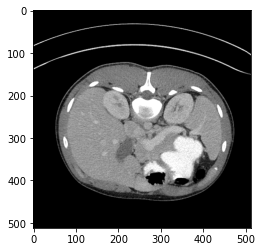

In [98]:
#scan = get_normalized(scan,-125,275)
plt.imshow(scan[85],'gray')


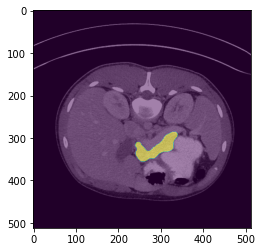

In [100]:
plt.imshow(scan[85],'gray')
plt.imshow(mask[85],alpha = 0.5)

C:\Users\Rabeea\Desktop\manifest-1599750808610\TCIA_pancreas_labels-02-05-2017\TCIA_pancreas_labels-02-05-2017\label0016.nii.gz


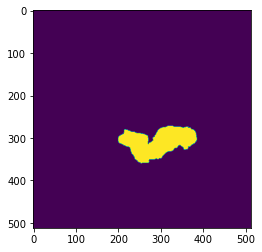

In [101]:
print(maskpath[10])
mask = nib.load(maskpath[0])
mask = mask.get_fdata()
mask = np.swapaxes(mask,0,2)
plt.imshow(np.amax(mask,axis = 0))


In [102]:
np.unique(mask)

array([0., 1.])

In [58]:
import os
a = []
for i in imgpath:
    a.append(len(os.listdir(i)))

(array([29., 29.,  4.,  0., 17.,  0.,  0.,  0.,  0.,  1.]),
 array([181. , 209.5, 238. , 266.5, 295. , 323.5, 352. , 380.5, 409. ,
        437.5, 466. ]),
 <BarContainer object of 10 artists>)

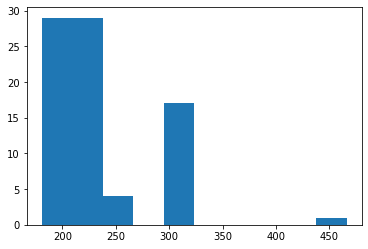

In [59]:
plt.hist(a)

In [30]:
scan.shape

(240, 512, 512)

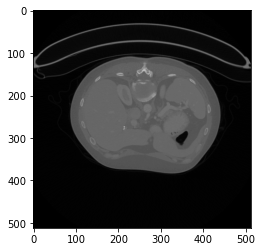

In [31]:
plt.imshow(scan[100,:,:],'gray')

In [ ]:
from tensorflow.keras.utils import Sequence


def parse_image(img_path, image_size):
    img = get_full_scan(img_path)
    img = get_normalized(img,-125,275) 
    img = res_scan(img, image_size)
    
    #mn = np.amin(img)
    #mx = np.amax(img)
    #d = mx - mn
    #img = (img-mn)/d
    #img = np.expand_dims(img, axis=2)
    #train_img = np.stack((image_rgb,)*3, axis=-1)
    
    return img

def parse_mask(mask_path, image_size):
    mask = nib.load(mask_path)
    mask = mask.get_fdata()
    mask = res_mask(mask, image_size)
    #mask = np.expand_dims(mask, axis=2)
    mask = mask.astype(np.uint8)
    #mask = np.where(mask>0,1,mask)
    return mask

class DataGen(Sequence):
    def __init__(self, image_size, images_path,mask_path, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]

        #images_batch = np.empty((self.batch_size,image_size[0],image_size[1],image_size[2],3))
        images_batch = np.empty((self.batch_size,image_size[0],image_size[1],image_size[2]))
        masks_batch = np.empty((self.batch_size,image_size[0],image_size[1],image_size[2]),dtype = 'uint8')

        for i in range(len(images_path)):
            # Read image and mask
            images_batch[i]= parse_image(images_path[i], self.image_size)
            masks_batch[i] = parse_mask(mask_path[i], self.image_size)

        #return np.array(images_batch), np.array(masks_batch)
        return images_batch,masks_batch

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))
    